# Neural Network Pruning
> How to make your network smaller and faster by removing useless parameters

- toc: true
- badges: false
- categories: [Deep Learning]
- comments: true
- image: images/granularity.png

## **The curse of racing for high performance**

While deep learning models are getting better in terms of performance, they also tend to get bigger and more expensive to compute. Until recently, it can seem that state-of-the-art models were achieved by using the good ol' ***“Stack more layers !”*** property. Indeed, if you take a look at the history of state-of-the-art models on ImageNet, you will notice that each year, the new best results were achieved by using a deeper network.

It seems that we are obsessed with getting the best results as possible, leading to models that can involve hundreds of millions of parameters ! But what's the point of having a top-tier performing network if we cannot use it?



<br>

<p style="font-size: 15px"><i>There <b>has</b> to be a better way to solve our tasks...</i></p>

<br>

After all, as the philosopher William of Occam argued in his principle named after him, the [Occam's Razor](http://math.ucr.edu/home/baez/physics/General/occam.html):

> “Pluralitas non est ponenda sine necessitate.”

Or in other words:

> “Simpler solutions should be favored over more complex ones.”




One of the ways to do so is to use a more parameter efficient architecture. There is a very active research going on in that field, and we can state some notable architectures that are competitive with their parameter-heavy equivalents ([SqueezeNet](https://arxiv.org/pdf/1602.07360.pdf){% fn 1 %}, [MobileNet](https://arxiv.org/pdf/1704.04861.pdf){% fn 2 %}, [Xception](https://arxiv.org/pdf/1610.02357.pdf){% fn 3 %}, [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf){% fn 4 %},...). 

<br>

### **Do we really need a sledgehammer to crack a nut ?**

What if I told you that you can still use your favorite architecture, but in a more efficient way ? After all, neural networks are meant to be used either on resource-constrained environments (mobile phones, autonomous cars, drones, ...) or to run on servers, so in both case, any gain in computation or memory storage would be beneficial.

Recently, there has been a very interesting paper by [Frankle and Carbin](https://arxiv.org/pdf/1803.03635.pdf){% fn 5 %}, where they introduce the *lottery ticket hypothesis*. This hypothesis states that, in a network, only a subset of the parameters is needed to achieve an optimal performance. The whole difficulty is then to find that particular subnetwork; the authors used a pruning technique consisting of pruning the trained model, then “rewinding” the initialization of remaining weights to their original initialization. Only that subnetwork, with that specific set of initialized weights is able to achieve the same level of accuracy as the entire network.

This discovery has huge implications, as it would imply that the only advantage of using parameter-heavy networks is to provide more initialization configuration and thus, more chance to get those “winning tickets”.

---

## **Pruning**

The [inspiration](https://en.wikipedia.org/wiki/Synaptic_pruning) behind neural network pruning is taken from how our own brain evolves during our life. Indeed, between our birth and adulthood, the amount of synapses (the structures that allows the neurons to transmit an electrical or chemical signal to another neuron) greatly varies. Our brain experience a large amount of growth during infancy, then basically follows a “use it or lose it” process. It results in a synaptic pruning which will remove any synapse that is not needed, in order to reach an optimal amount depending on our needs.

!['Synapses'](images/pruning/synapses_black.svg "Source: Rethinking the Brain: New Insights into Early Development")


In the case of neural networks, the principle of pruning is to remove network connections that are considered *unimportant* to keep the network performance unchanged. Pruning is actually a quite old idea (like most ideas of deep learning) but that is an active field of research nowadays.

It dates back to 1990s namely, with most popular work at that time being [Optimal Brain Damage](https://papers.nips.cc/paper/250-optimal-brain-damage.pdf) {% fn 6 %} and  [Optimal Brain Surgeon](https://papers.nips.cc/paper/749-optimal-brain-surgeon-extensions-and-performance-comparisons.pdf) {% fn 7 %}. Pruning has been popularized by [Han et al.](https://arxiv.org/abs/1506.02626) {% fn 8 %} with their 2015 paper.

!['Pruning'](images/pruning/pruning_black.svg)



Pruning thus consists of inducing sparsity in the weights of the network.

> “Every block of stone has a statue inside it and it is the task of the sculptor to discover it.” - **Michelangelo**

As Michelangelo and his blocks of stone, we will carve our neural networks to bring their beauty out of them, or until we make them as sparse as possible while preserving their original performance.

<br>

### **Granularity**

Neural network pruning can come in many fashion, represented in the image below: 


!['Synapses'](images/pruning/granularity_black.svg "Inspired by Mao et al., Exploring the Regularity of Sparse Structure in Convolutional Neural Networks")


You can either be very precise and remove each weight independently or remove bigger chunks at a time. The more fine-grained (or *unstructured*) the pruning, the more precise the process will be, but the more difficult it will be to get any acceleration. On the other hand, removing bigger chunks at a time (*structured pruning*) will be less accurate, but will make life easier for any sparse matrix computation libraries. So granularity of pruning will be a trade-off between precision and acceleration. 

<br>

<p style="font-size: 15px"><i>I guess it's a matter of preference, are you more a <b>cubist</b> or <b>high renaissance</b> deep learning artist ?</i></p>

<br>

Apart from the granularity of pruning, you also have to choose **when** you will remove the weights.

<br>

### **Scheduling**

The timing and scheduling that you will adopt to prune your network will highly impact its final performance. 

The three most commonly used schedulings are:
- **One-shot Pruning**
- **Iterative Pruning**
- **Automated Gradual Pruning**


The most basic idea is to start from a trained model, prune it to the desired sparsity, then optionally fine-tune the network to accommodate from the removal of some of its parameters. This technique is known as ***One-shot Pruning***. However, a simple change in that technique is able to provide way better results. The idea is simply to perform the pruning phase over several steps, all followed by some fine-tuning. That technique is called ***Iterative Pruning*** and, while leading to better results, can sometimes be very time-consuming and computationally intensive, especially if the number of parameters removed at each iteration is low. There has also been [some research](https://arxiv.org/abs/1710.01878){% fn 9 %} in incorporating weight pruning directly **inside** of the training step, periodically removing the weights. This technique is called ***Automated Gradual Pruning***.

<br>

!['Pruning'](images/pruning/schedules_black.svg)

<br>

In the case of Automated Gradual Pruning, the schedule proposed by the authors is the following:

#hide
$$
\large
s_{t}=s_{f}+\left(s_{i}-s_{f}\right)\left(1-\frac{t-t_{0}}{n \Delta t}\right)^{3} \text { for } t \in\left\{t_{0}, t_{0}+\Delta t, \ldots, t_{0}+n \Delta t\right\}
$$

!['Pruning'](images/pruning/grad.svg)

This schedule leads to an important pruning early in the training, then slowly decreasing as the training progresses.

<br>

### **Criteria**

Now that we know how and when to remove our parameters, we have to know **which** ones to choose.

There exist many ways to evaluate weights importance, but the two most common ways are:

- **Weight Magnitude Pruning**
- **Gradient Magnitude Pruning**

While being extremely simple, weight magnitude pruning has been found to be very effective. It simply consists of computing the $L1$-norm, i.e $\sum_{i}\left|x_{i}\right|$, of the weights (or group/kernel/filter depending on the granularity), and to remove the ones with the lowest values. In the case of gradient magnitude pruning, the only change is that we will multiply our weights by their corresponding gradients before computing the $L1$-norm on the result.

Those criteria can be evaluated **locally**, i.e. each channel is pruned until the desired sparsity is reached, resulting in equally sparse layers, or **globally**, i.e. we evaluate the weights over the whole network, resulting in a sparse network, but with layers having different sparsity values.

<br>

### **Evaluation**

In order to report how well a pruning technique is doing, you need metrics to evaluate it.

To avoid any ambiguity in the metrics used, [Davis Blalock and Jose Javier Gonzalez Ortiz](https://arxiv.org/pdf/2003.03033.pdf){% fn 10 %} have proposed a [library](https://github.com/JJGO/shrinkbench/tree/master/) to unify the way we report metrics. More specifically, they propose to report: 

- **Compression Ratio**, which should be computed as: `Compression Ratio = total_params/nonzero_params`, with `total_params` being the original number of parameters in the network and `nonzero_params` the number of non-zero weights after pruning. 

- **Theoretical Speedup**, which should be computed as: `Speedup = total_flops/nonzero_flops`, with `total_flops` being the amount of FLOPs in the original model and `nonzero_flops` the amount of FLOPs of the remaining non-zero weights.

It is important to report both metrics as the speedup greatly depends on **where** in the network the pruning is performed. Indeed, for a same compression ratio, two similar architectures can have widely different speedup values. This is because the FLOPs of the convolution operation highly depend on the size of their input dimension, which varies along the network. Most of parameters are usually contained towards the end of the network while most of the computation is performed in early layers, reason why early downsampling is widely used.

The graph below show how the number of parameters and FLOPs evolve in the VGG16 network:

!['Pruning'](images/pruning/params_vgg_black.svg)

What it shows is that, the last 3 layers hold $48\%$ of the parameters while being only responsible of $9\%$ of the total FLOPs in the network. For that reason, in order to see the same speedup improvement, you will need to remove a lot more parameters in late layers than you would need in early layers.

Another problem remaining is that the reported speedup is a **theoretical value**. It means that you'll never observe such a speedup in reality, especially because common deep learning libraries do not support acceleration for sparse matrices, or that it requires dedicated hardware. The easiest way to make sure that you will get an inference speed improvement is to physically remove the weights (can only be done for [entire filters](https://arxiv.org/pdf/1608.08710.pdf) {% fn 11 %}), you don't need to take care of sparse matrix computations if you don't have the matrix anymore! The way to perform that operation for a layer $i$ is the following:

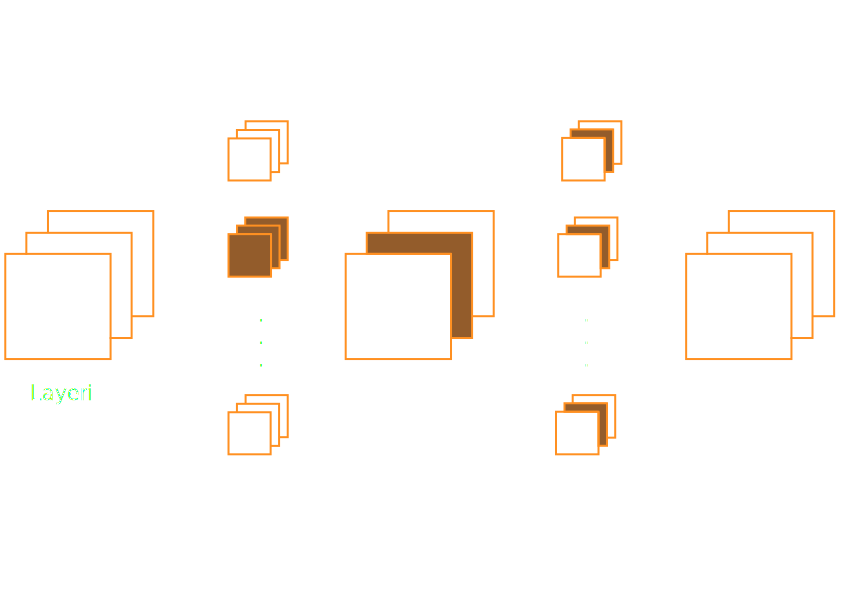

In [6]:
#hide_input
from IPython.display import SVG, display
display(SVG(data='images/pruning/filter_pruning.svg'))

As you remove a whole filter, it's not really introducing sparsity in the network as you now change a hyperparameter (number of filters in a layer). Moreover, if you decide to prune a single filter in layer $i$, it means that the corresponding feature map won't exist anymore. Thus, in the layer $i+1$, the kernels corresponding to the deleted feature maps have to be removed. So, pruning a filter saves parameters and computations both in the current layer and in the following one!

<br>

**That's all! Thank you for reading, I hope that you found this little tour over neural network pruning interesting and, more importantly, useful.**

<br>

---

<br>

<p style="font-size: 15px"><i>If you notice any mistake or improvement that can be done, please contact me ! If you found that post useful, please consider citing it as:</i></p>

```
@article{hubens2020pruning,
  title   = "Neural Network Pruning",
  author  = "Hubens, Nathan",
  journal = "nathanhubens.github.io",
  year    = "2020",
  url     = "https://nathanhubens.github.io/posts/deep%20learning/2020/05/22/pruning.html"
}
```

<br>

## **References**

- {{'[Howard A. et al., SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and <1MB model size. ICLR, 2017](http://arxiv.org/abs/1803.03635)' | fndetail: 1}}

- {{'[Forrest N. Iandola et al., MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications. CoRR, abs/1704.04861, 2017](http://arxiv.org/abs/1704.04861)' | fndetail: 2}}

- {{'[Chollet F., Xception: Deep Learning with Depthwise Separable Convolutions. CVPR, 2017](https://doi.org/10.1109/CVPR.2017.195)' | fndetail: 3}}

- {{'[Mingxing T. and Quoc V. Le, EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. ICML, 2019](http://proceedings.mlr.press/v97/tan19a.html)' | fndetail: 4}}

- {{'[Frankle, J. & Carbin, M., The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks. ICLR, 2019](http://arxiv.org/abs/1803.03635)' | fndetail: 5}}

- {{'[LeCun Y. and Denker J. and Solla S., Optimal Brain Damage, NeurIPS, 1990](http://papers.nips.cc/paper/250-optimal-brain-damage.pdf)' | fndetail: 6}}

- {{'[Hassibi, Babak and David G. Stork and Wolff, Gregory, Optimal Brain Surgeon: Extensions and performance comparisons, NeurIPS, 1993](http://papers.nips.cc/paper/749-optimal-brain-surgeon-extensions-and-performance-comparisons.pdf)' | fndetail: 7}}

- {{'[Han S. et al., Learning both Weights and Connections for Efficient Neural Networks, NeurIPS, 2015](http://arxiv.org/abs/1506.02626)' | fndetail: 8}}

- {{'[Zhu, M. & Gupta, S. To prune, or not to prune: exploring the efficacy of pruning for model compression. ICLR, 2018](https://arxiv.org/abs/1710.01878)' | fndetail: 9}}

- {{'[Blalock D.,Gonzalez Ortiz J.,Frankle J., and Guttag J., What is the state of neural network pruning?. MLSys, 2020](http://arxiv.org/abs/1803.03635)' | fndetail: 10}}

- {{'[Hao Li et al., Pruning Filters for Efficient ConvNets, ICLR, 2017](https://arxiv.org/pdf/1608.08710.pdf)' | fndetail: 11}}